## Problem Statement

I am a co-founder of a small tech company which wants to develop an online streaming platform naming 'NetSpot' with a desire to compete with Netflix and Spotify. We want to serve the consumer with both movies and music on a same online platform. We also want to place a blog section where user can leave their reviews, stories and start any discussion. As a part of it we want to establish a model which can segregate the posts based on their title text so when someone searches for ‘movies’ or ‘music’, the relevant posts show up for them. Also, the model will help us to understand the users’ usage pattern, demand in future fore further business expansion. As a part of this project we want to try different classification models and select the best model that satisfy our target.

## Executive Summary

## Table of contents

## 1. Library import 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import nltk
from nltk.stem import WordNetLemmatizer #Import lemmatizer
from nltk.tokenize import RegexpTokenizer # Import Tokenizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import TransformerMixin
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
RANDOM_STATE = 42

## 2. Import Data

In [2]:
df_movie = pd.read_csv("./Data/data_movies.csv")

In [3]:
df_music = pd.read_csv("./Data/data_music.csv")

In [4]:
print(df_movie.shape)
print(df_music.shape)

(2723, 9)
(2014, 9)


In [5]:
df = df_movie.append(df_music)

In [6]:
df.shape

(4737, 9)

In [7]:
df[:2]

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Need help to find a name of cyberpunk movie I ...,[removed],movies,1584584017,slvrbat,0,1,True,2020-03-18
1,my coronavirus movie picks,pls comment if you want too add films or categ...,movies,1584584059,Bobatron1010,13,2,True,2020-03-18


## 3. Data Cleaning 

In [8]:
df.duplicated().sum()  #checking duplicate

0

In [9]:
df

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Need help to find a name of cyberpunk movie I ...,[removed],movies,1584584017,slvrbat,0,1,True,2020-03-18
1,my coronavirus movie picks,pls comment if you want too add films or categ...,movies,1584584059,Bobatron1010,13,2,True,2020-03-18
2,Need Help deciding a movie to watch,[removed],movies,1584584341,Shidoitsukasan,0,1,True,2020-03-18
3,Need help deciding what to watch,[removed],movies,1584584378,Shidoitsukasan,0,1,True,2020-03-18
4,Would anyone else like to see Arnold in a film...,[removed],movies,1584585786,sirjackiechiles,0,1,True,2020-03-18
...,...,...,...,...,...,...,...,...,...
2009,Check out our post on alternative guest book i...,[removed],Music,1535389865,steelasophical,0,1,True,2018-08-27
2010,Soundcloud beats,"yoyo, im a young soundcloud beatmaker tryna pr...",Music,1535390701,bitchwhasyoname,4,0,True,2018-08-27
2011,Can anyone recommend any lesser known guitaris...,Looking for some nice blues rock with great so...,Music,1535391072,alonabc,1,1,True,2018-08-27
2012,'Sharp Objects' Music Supervisor Susan Jacobs ...,\n\nMusic supervisor Susan Jacobs is a condui...,Music,1535391300,jenelyngalve,3,4,True,2018-08-27


In [10]:
#assigning values to target variable 

df['subreddit'] = [1 if i == 'movies' else 0 for i in df['subreddit']]  

In [11]:
# writing function to clean title

def review_to_title(title):
    
    # 2. Remove non-letters.
    title = re.sub("[^a-zA-Z]", " ", title)
    
    # 3. Convert to lower case
    title = title.lower()
    
    # Remove hashtags
    title = re.sub(r'#\w*', '', title)
    
    # Remove HTML special entities (e.g. &amp;)
    title = re.sub(r'\&\w*;', '', title)
    
    #punctuation
    title = re.sub(r'[?|!|\'|#]', r'', title)
    
    # Remove hyperlinks
    title = re.sub(r'https?:\/\/.*\/\w*', '', title)
    
    # Remove whitespace (including new line characters)
    title = re.sub(r'\s\s+', ' ', title)
    
    return title 

In [12]:
df['title'] = df['title'].map(review_to_title)

In [13]:
df.shape

(4737, 9)

In [14]:
df['title'].isnull().sum()  #checking null values

0

In [15]:
# Lemmatizing

lemmatizer = WordNetLemmatizer()

def lemmatize_words(title):
    words = title.split()
    lemma_words = ''
    for word in words:
        lemma_words += (lemmatizer.lemmatize(word) + ' ')
    return lemma_words

In [16]:
df['title'] = df['title'].apply(lemmatize_words)

## 4. Pre-processing corpus

### Brief exploration on corpus 

In [18]:
#countvectorizer on whole data 

count_vect = CountVectorizer(
                             analyzer = "word", 
                             stop_words = "english", 
                             max_features = 1000,
                             ngram_range= (1,2)
                            )

df_words = count_vect.fit_transform(df['title'])  #fit_transform the vectorizer
df_words = df_words.toarray() #output

In [19]:
print(list(count_vect.get_feature_names())[:15])

['able', 'absolutely', 'acoustic', 'action', 'action movie', 'actor', 'actor actress', 'actress', 'actually', 'ad', 'ad astra', 'adaptation', 'add', 'added', 'adventure']


In [20]:
covec_df = pd.DataFrame(df_words, columns = count_vect.get_feature_names()) # creating a dataframe

Text(0, 0.5, 'words')

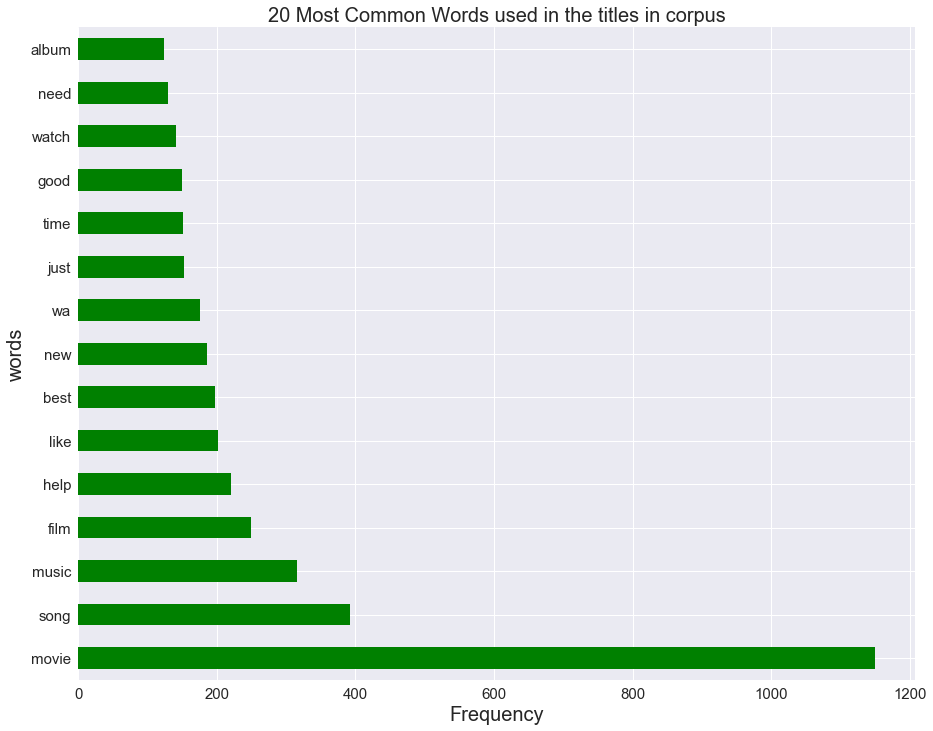

In [167]:
plt.style.use('seaborn')
plt.figure(figsize = (15,12))
covec_df.sum().sort_values(ascending=False).head(15).plot(kind = 'barh', color ='g', fontsize = 15)
plt.title("20 Most Common Words used in the titles in corpus", fontsize = 20)
plt.xlabel('Frequency', fontsize =20)
plt.ylabel ('words', fontsize = 20)

In [143]:
print(len(df['title']))

4737


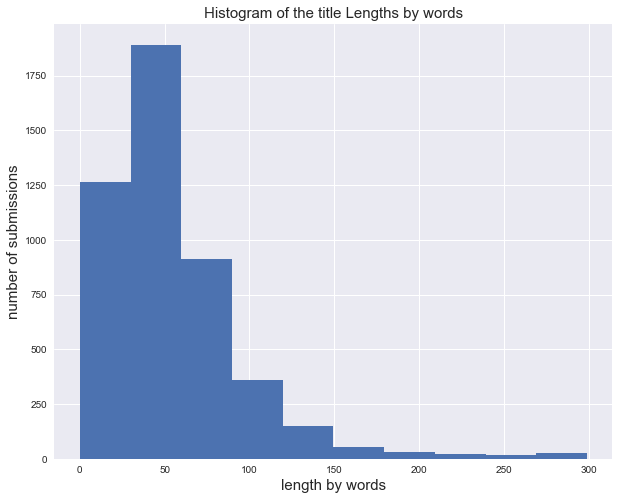

In [174]:
plt.style.use('seaborn')
plt.figure(figsize = (10,8))
lengths_of_posts = [len(each) for each in df['title']]  #adopted code from Noah
plt.hist(lengths_of_posts)
plt.xlabel('length by words', fontsize =15)
plt.ylabel ('number of submissions', fontsize = 15)
plt.title('Histogram of the title Lengths by words', fontsize = 15);

Text(0, 0.5, 'subreddit:    1 = Movie  0 = Music')

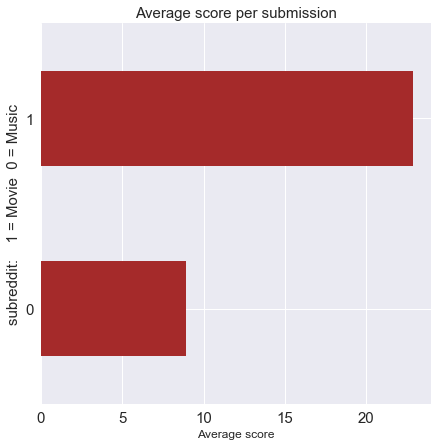

In [175]:
plt.style.use('seaborn')
plt.figure(figsize = (7,7))
df.groupby('subreddit')['score'].mean().plot(kind='barh', color ='brown', fontsize = 15);
plt.title('Average score per submission', fontsize = 15)
plt.xlabel('Average score', fontsize =12)
plt.ylabel ('subreddit:    1 = Movie  0 = Music', fontsize = 15)

### Brief exploration on movies and music dataset individually

### _Counvectorizer_

In [92]:
#most frequent words for movies

count_vect = CountVectorizer(
                             analyzer = "word", 
                             stop_words = "english", 
                             max_features = 1000,
                             ngram_range= (1,2)
                            )

vector_input_music = df[df['subreddit'] == 1]['title']  # input for CountVectorizer
movie_words = count_vect.fit_transform(vector_input_music)  #fit_transform the vectorizer
movie_words = movie_words.toarray() #output

In [93]:
print(list(count_vect.get_feature_names())[:15])

['able', 'absolutely', 'acting', 'action', 'action movie', 'actor', 'actor actress', 'actress', 'actually', 'ad', 'ad astra', 'adaptation', 'added', 'adventure', 'ago']


In [96]:
covec_movie = pd.DataFrame(movie_words, columns = count_vect.get_feature_names())  #creating Dataframe

Text(0, 0.5, 'words')

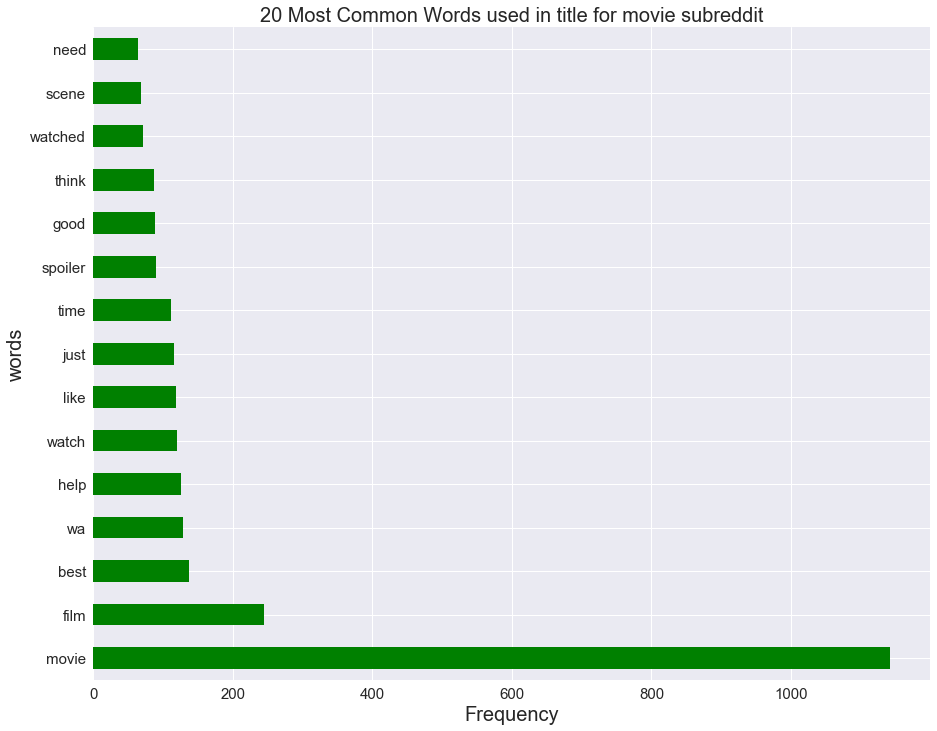

In [135]:
plt.style.use('seaborn')
plt.figure(figsize = (15,12))
covec_movie.sum().sort_values(ascending= False).head(15).plot(kind = 'barh', color ='g', fontsize = 15)
plt.title("20 Most Common Words used in title for movie subreddit", fontsize = 20)
plt.xlabel('Frequency', fontsize =20)
plt.ylabel ('words', fontsize = 20)

In [131]:
#most frequent words for music

count_vect = CountVectorizer(
                            analyzer = "word", 
                             stop_words = "english", 
                             max_features = 1000,
                             ngram_range=(1, 2)
                            ) 

vector_input_music = df[df['subreddit'] == 0]['title'] # input for CountVectorizer

music_words = count_vect.fit_transform(vector_input_music) #fit_transform the vectorizer

music_words = music_words.toarray() #output 

In [132]:
print(list(count_vect.get_feature_names())[:15])

['acoustic', 'african', 'ago', 'air', 'alan', 'alan walker', 'album', 'album cover', 'album review', 'album year', 'album zip', 'alex', 'alt', 'alternative', 'alternative rock']


In [133]:
covec_music = pd.DataFrame(music_words, columns = count_vect.get_feature_names()) #creating Dataframe

Text(0, 0.5, 'words')

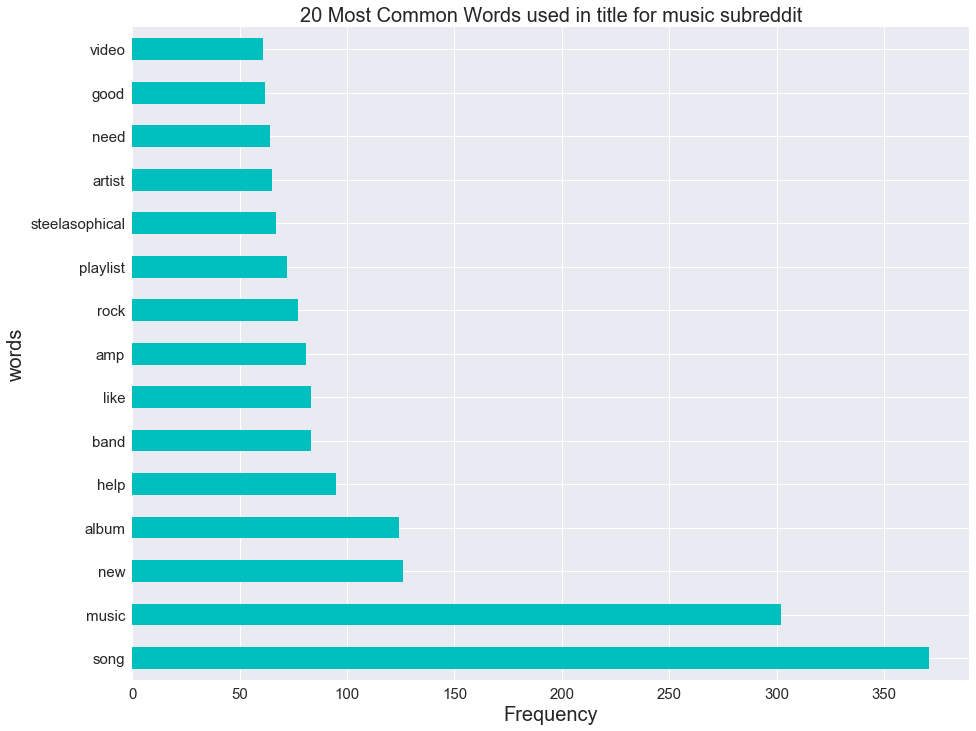

In [136]:
plt.style.use('seaborn')
plt.figure(figsize = (15,12))
covec_music.sum().sort_values(ascending=False).head(15).plot(kind = 'barh', color ='c', fontsize = 15)
plt.title("20 Most Common Words used in title for music subreddit", fontsize = 20)
plt.xlabel('Frequency', fontsize =20)
plt.ylabel ('words', fontsize = 20)

### _TF-IDF Vectorizer_

In [30]:
#tfidf vectorizer for movie words

tfdf = TfidfVectorizer(
                     analyzer = "word", 
                     stop_words = 'english', 
                     max_features = 10000, 
                     ngram_range = (1, 2)
                         )

tfdf_input_movie = df[df['subreddit'] == 1]['title']  # input for CountVectorizer

tfdf_movie_words = tfdf.fit_transform(tfdf_input_movie) #fit-transform

tfdf_movie_words = tfdf_movie_words.toarray() #output

tfdf_movie = pd.DataFrame(tfdf_movie_words, columns=tfdf.get_feature_names())  #create Dataframe

tfdf_movie.sum().sort_values(ascending=False).head(10)  

movie      170.736088
film        43.897307
help        40.614416
best        32.627449
watch       27.695621
wa          24.072006
like        23.337639
time        22.249508
good        21.254840
spoiler     20.900867
dtype: float64

In [31]:
#tfidf vectorizer for music words

tfdf = TfidfVectorizer(
                     analyzer = "word", 
                     stop_words = 'english', 
                     max_features = 10000, 
                     ngram_range = (1, 2)
                         )

tfdf_input_music = df[df['subreddit'] == 0]['title']  # input for CountVectorizer

tfdf_music_words = tfdf.fit_transform(tfdf_input_music) #fit-transform

tfdf_music_words = tfdf_music_words.toarray() #output

tfdf_music = pd.DataFrame(tfdf_music_words, columns=tfdf.get_feature_names())  #create Dataframe

tfdf_music.sum().sort_values(ascending=False).head(10)  

song        68.327028
music       49.640428
help        33.010439
album       24.046394
new         23.307100
band        17.784376
looking     17.755175
need        17.753946
playlist    16.433595
genre       16.352990
dtype: float64

## 5. Model Preparation

In [244]:
X = df['title']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.40, random_state=RANDOM_STATE)

## 6. Modelling 

### Baseline Model

Baseline model is actually the mean value of target varaibles. Both train and test set has two means each, one for music ( y = 0) and one for movies (y = 1). The best of this two mean is choosen as the best baseline score for each set.

In [184]:
print('Best baseline accuracy on TRAIN set:', y_train.value_counts(normalize=True).max())
print('Best baseline accuracy on TEST set:', y_test.value_counts(normalize=True).max())

Best baseline accuracy on TRAIN set: 0.5749472202674173
Best baseline accuracy on TEST set: 0.5746701846965699


### CVEC + Logistic Regression

In [237]:
# Instantiate pipeline.
pipe_cv = Pipeline([
    ('cv', CountVectorizer()),
    ('logit', LogisticRegression(solver = 'lbfgs'))
])

# Define grid of parameters to GridSearch over.
params_grid = {
    'cv__max_features': [1000, 1500],
    'cv__stop_words': ['english'],
    'cv__ngram_range': [(1,1), (1,2)]
}

# GridSearch over pipeline with given grid of parameters.
logit_cv = GridSearchCV(pipe_cv, 
                     params_grid, 
                     cv=5, 
                     scoring ='accuracy')

# Fit model.
logit_cv.fit(X_train, y_train);

In [238]:
logit_cv.best_params_

{'cv__max_features': 1500,
 'cv__ngram_range': (1, 1),
 'cv__stop_words': 'english'}

In [241]:
logit_cv.best_estimator_ ;

In [198]:
train_score = logit_cv.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(train_score))
test_score = logit_cv.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))

Best TRAIN set accuracy: 0.8716
Best TEST set accuracy: 0.8744


In [242]:
y_preds = logit_cv.predict(X_test);
confusion_matrix(y_test, y_preds);
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel();

print('Classification metric:')
print("accuracy:               {:.4f} ".format(((tp + tn)/(tp + tn + fp + fn))))
print("missclassification:     {:.4f} ".format(1 - ((tp + tn)/(tp + tn + fp + fn))))
print("sensitivity:            {:.4f}".format((tp /(tp+fn))))
print("specificity:            {:.4f} ".format((tn/(tn+fp))))
print("precise:                {:.4f} ".format((tp/(tp+fp))))

Classification metric:
accuracy:               0.8744 
missclassification:     0.1256 
sensitivity:            0.8843
specificity:            0.8610 
precise:                0.8958 


### TF-IDF + Logistic Regression

In [203]:
# Instantiate pipeline.
pipe_tf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('logit', LogisticRegression())
])

# Define grid of parameters to GridSearch over.
params_grid = {
    'tf__max_features': [1000, 1500],
    'tf__stop_words': ['english'],
    'tf__ngram_range': [(1,1), (1,2)]
}

# GridSearch over pipeline with given grid of parameters.
logit_tf = GridSearchCV(pipe_tf, params_grid, cv=5)

# Fit model.
logit_tf.fit(X_train, y_train);

In [204]:
logit_tf.best_params_

{'tf__max_features': 1500,
 'tf__ngram_range': (1, 1),
 'tf__stop_words': 'english'}

In [205]:
logit_tf.best_estimator_ ;

In [206]:
train_score = logit_tf.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(train_score))
test_score = logit_tf.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))

Best TRAIN set accuracy: 0.8698
Best TEST set accuracy: 0.8728


In [207]:
y_preds = logit_tf.predict(X_test);
confusion_matrix(y_test, y_preds);
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel();

print('Classification metric:')
print("accuracy:               {:.4f} ".format(((tp + tn)/(tp + tn + fp + fn))))
print("missclassification:     {:.4f} ".format(1 - ((tp + tn)/(tp + tn + fp + fn))))
print("sensitivity:            {:.4f}".format((tp /(tp+fn))))
print("specificity:            {:.4f} ".format((tn/(tn+fp))))
print("precise:                {:.4f} ".format((tp/(tp+fp))))

Classification metric:
accuracy:               0.8728 
missclassification:     0.1272 
sensitivity:            0.9412
specificity:            0.7804 
precise:                0.8527 


### CVEC + KNN

In [208]:
# Simple pipeline - list of tuples
pipe_cv = Pipeline(steps=[
    ('cv', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

#Params-dictionary
pipe_params = { 'cv__max_features': [1000, 1500],
                 'cv__stop_words': ['english'],
                 'cv__ngram_range': [(1,1), (1,2)],
                 'knn__metric': ['minkowski','euclidean', 'manhattan'],
                'knn__n_neighbors': [3, 5]}

knn_cv = GridSearchCV(pipe_cv, 
                    pipe_params, 
                    cv = 5)

knn_cv.fit(X_train, y_train);

In [209]:
knn_cv.best_estimator_ ;

In [210]:
knn_cv.best_score_

0.7994350107675933

In [211]:
train_score = knn_cv.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(train_score))
test_score = knn_cv.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))

Best TRAIN set accuracy: 0.7994
Best TEST set accuracy: 0.7831


In [212]:
y_preds = knn_cv.predict(X_test);
confusion_matrix(y_test, y_preds);
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel();

print('Classification metric:')
print("accuracy:               {:.4f} ".format(((tp + tn)/(tp + tn + fp + fn))))
print("missclassification:     {:.4f} ".format(1 - ((tp + tn)/(tp + tn + fp + fn))))
print("sensitivity:            {:.4f}".format((tp /(tp+fn))))
print("specificity:            {:.4f} ".format((tn/(tn+fp))))
print("precise:                {:.4f} ".format((tp/(tp+fp))))

Classification metric:
accuracy:               0.7831 
missclassification:     0.2169 
sensitivity:            0.8246
specificity:            0.7270 
precise:                0.8032 


## TF-IDF + KNN

In [214]:
# Simple pipeline - list of tuples
pipe_tf = Pipeline(steps=[
    ('tfdf', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

#Params-dictionary
pipe_params = { 'tfdf__max_features': [1000, 1500],
                 'tfdf__stop_words': [{'english'}],
                 'tfdf__ngram_range': [(1,1), (1,2)],
                 'knn__metric': ['minkowski','euclidean', 'manhattan'],
                 'knn__n_neighbors': [3, 5]}

knn_tf = GridSearchCV(pipe_tf, 
                    pipe_params, 
                    cv = 5) 
                               
knn_tf.fit(X_train, y_train);

In [215]:
knn_tf.best_estimator_ ;

In [216]:
knn_tf.best_score_

0.7132286690264611

In [217]:
train_score = knn_tf.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(train_score))
test_score = knn_tf.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))

Best TRAIN set accuracy: 0.7132
Best TEST set accuracy: 0.7245


In [218]:
y_preds = knn_tf.predict(X_test);
confusion_matrix(y_test, y_preds);
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel();

print('Classification metric:')
print("accuracy:               {:.4f} ".format(((tp + tn)/(tp + tn + fp + fn))))
print("missclassification:     {:.4f} ".format(1 - ((tp + tn)/(tp + tn + fp + fn))))
print("sensitivity:            {:.4f}".format((tp /(tp+fn))))
print("specificity:            {:.4f} ".format((tn/(tn+fp))))
print("precise:                {:.4f} ".format((tp/(tp+fp))))

Classification metric:
accuracy:               0.7245 
missclassification:     0.2755 
sensitivity:            0.8990
specificity:            0.4888 
precise:                0.7038 


### CVEC + Naive bayes (Multinomial)

In [53]:
# Simple pipeline - list of tuples
pipe_cv = Pipeline(steps=[
    ('cv', CountVectorizer()),
    ('multNB', MultinomialNB())
])

#Params-dictionary
pipe_params = { 'cv__max_features': [1000, 1500],
                 'cv__stop_words': [{'english'}],
                 'cv__ngram_range': [(1,1), (1,2)]}

gs_multNB = GridSearchCV(pipe_cv, 
                    pipe_params, 
                    cv = 5) 
                               
gs_multNB.fit(X_train, y_train);

In [54]:
gs_multNB.best_estimator_ ;

In [55]:
gs_multNB.best_score_

0.8764975618208372

In [187]:
train_score = gs_multNB.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(train_score))
test_score = gs_multNB.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))

Best TRAIN set accuracy: 0.8765
Best TEST set accuracy: 0.8792


In [57]:
y_preds = gs_multNB.predict(X_test);
confusion_matrix(y_test, y_preds);
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel();

print('Classification metric:')
print("accuracy:               {:.4f} ".format(((tp + tn)/(tp + tn + fp + fn))))
print("missclassification:     {:.4f} ".format(1 - ((tp + tn)/(tp + tn + fp + fn))))
print("sensitivity:            {:.4f}".format((tp /(tp+fn))))
print("specificity:            {:.4f} ".format((tn/(tn+fp))))
print("precise:                {:.4f} ".format((tp/(tp+fp))))

Classification metric:
accuracy:               0.8792 
missclassification:     0.1208 
sensitivity:            0.9513
specificity:            0.7816 
precise:                0.8548 


### TD-IDF + Naive bayes (Gaussian )

In [58]:
# adapted from https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [59]:

pipe_tf = Pipeline(steps=[
    ('tfdf', TfidfVectorizer()),
    ("_",DenseTransformer()),
    ('gasNB', GaussianNB())
])

pipe_params = { 'tfdf__max_features': [1000, 1500],
                 'tfdf__stop_words': [{'english'}],
                 'tfdf__ngram_range': [(1,1), (1,2)]}

gs_gasNB = GridSearchCV(pipe_tf, 
                    pipe_params, 
                    cv = 5) 



gs_gasNB.fit(X_train, y_train);

In [60]:
gs_gasNB.best_estimator_ ;

In [61]:
gs_gasNB.best_score_

0.7645975147899701

In [188]:
train_score = gs_gasNB.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(train_score))
test_score = gs_gasNB.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))

Best TRAIN set accuracy: 0.7646
Best TEST set accuracy: 0.7646


In [63]:
y_preds = gs_gasNB.predict(X_test);
confusion_matrix(y_test, y_preds);
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel();

print('Classification metric:')
print("accuracy:               {:.4f} ".format(((tp + tn)/(tp + tn + fp + fn))))
print("missclassification:     {:.4f} ".format(1 - ((tp + tn)/(tp + tn + fp + fn))))
print("sensitivity:            {:.4f}".format((tp /(tp+fn))))
print("specificity:            {:.4f} ".format((tn/(tn+fp))))
print("precise:                {:.4f} ".format((tp/(tp+fp))))

Classification metric:
accuracy:               0.7646 
missclassification:     0.2354 
sensitivity:            0.6749
specificity:            0.8859 
precise:                0.8888 


In [ ]:
def cm(model):
    

### CVEC + Decision Tree

In [64]:
# Simple pipeline - list of tuples
cvec_tree_pipe = Pipeline(steps=[
    ('cv', CountVectorizer()),
    ('tree', DecisionTreeClassifier())
])

#Params-dictionary
cvec_tree_params = {'cv__max_features': [1000, 1500],
                 'cv__stop_words': [{'english'}],
                 'cv__ngram_range': [(1,1), (1,2)],
                    'cv__min_df': [5],
                    'cv__max_df': [.5,.1,.2],
                 'tree__max_depth': [10,15,20],
                 'tree__min_samples_leaf': [2],
                  'tree__min_samples_split': [3]}

gs_tree = GridSearchCV(cvec_tree_pipe, 
                    cvec_tree_params, 
                    cv = 5) 
                               
gs_tree.fit(X_train, y_train);

In [65]:
gs_tree.best_estimator_ ;

In [66]:
gs_tree.best_score_

0.7853628802693136

In [189]:
train_score = gs_tree.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(train_score))
test_score = gs_tree.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))

Best TRAIN set accuracy: 0.7854
Best TEST set accuracy: 0.7741


In [68]:
y_preds = gs_tree.predict(X_test);
confusion_matrix(y_test, y_preds);
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel();

print('Classification metric:')
print("accuracy:               {:.4f} ".format(((tp + tn)/(tp + tn + fp + fn))))
print("missclassification:     {:.4f} ".format(1 - ((tp + tn)/(tp + tn + fp + fn))))
print("sensitivity:            {:.4f}".format((tp /(tp+fn))))
print("specificity:            {:.4f} ".format((tn/(tn+fp))))
print("precise:                {:.4f} ".format((tp/(tp+fp))))

Classification metric:
accuracy:               0.7741 
missclassification:     0.2259 
sensitivity:            0.9642
specificity:            0.5174 
precise:                0.7297 


The scores suggest that above CART model is an overfit model (accuracy on train set is higher than the accuracy on test set). Therefore, we should try bagging classification model.

### CVCE + BaggingClassifier

In [69]:
# Simple pipeline - list of tuples
cvec_bagg_pipe = Pipeline(steps=[
    ('cvec', CountVectorizer()),
    ('bagg', BaggingClassifier(base_estimator=DecisionTreeClassifier()))
])

#Params-dictionary
cvec_bagg_params = { 'cvec__max_features': [1000, 1500],
                 'cvec__stop_words': [{'english'}],
                    'cvec__min_df': [5],
                    'cvec__max_df': [.5],
                 'cvec__ngram_range': [(1,1), (1,2)],
                 'bagg__n_estimators': [10], 
                  'bagg__max_samples': [.5]
                    }             

gs_bagg = GridSearchCV(cvec_bagg_pipe, 
                    cvec_bagg_params,
                      cv= 5) 
                               
gs_bagg.fit(X_train, y_train);

In [70]:
 gs_bagg.best_estimator_ ;

In [71]:
gs_bagg.best_score_

0.835682813931038

In [190]:
train_score = gs_bagg.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(train_score))
test_score = gs_bagg.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))

Best TRAIN set accuracy: 0.8357
Best TEST set accuracy: 0.8385


In [73]:
y_preds = gs_bagg.predict(X_test);
confusion_matrix(y_test, y_preds);
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel();

print('Classification metric:')
print("accuracy:               {:.4f} ".format(((tp + tn)/(tp + tn + fp + fn))))
print("missclassification:     {:.4f} ".format(1 - ((tp + tn)/(tp + tn + fp + fn))))
print("sensitivity:            {:.4f}".format((tp /(tp+fn))))
print("specificity:            {:.4f} ".format((tn/(tn+fp))))
print("precise:                {:.4f} ".format((tp/(tp+fp))))

Classification metric:
accuracy:               0.8385 
missclassification:     0.1615 
sensitivity:            0.8485
specificity:            0.8251 
precise:                0.8676 


Bagging classification model is an underfit model as accuracy score on train set is lower than the accuracy score on test set. So, actually we don't need to try other classification models.

## Evaluation

In [222]:
print('Accuracy score for Baleline model: {:.4f}'.format(y_test.value_counts(normalize=True).max()))
print('Accuracy score for CVCE + Logistic Reg.: {:.4f}'.format(logit_cv.score(X_test, y_test)))
print('Accuracy score for TD-IDF + Logistic Reg.: {:.4f}'.format(logit_tf.score(X_test, y_test)))
print('Accuracy score for CVEC + KNN.: {:.4f}'.format(knn_cv.score(X_test, y_test)))
print('Accuracy score for TD-IDF + KNN.: {:.4f}'.format(knn_tf.score(X_test, y_test)))
print('Accuracy score for CVEC + Multinomial.: {:.4f}'.format(gs_multNB.score(X_test, y_test)))
print('Accuracy score for CVEC + Gaussaian.: {:.4f}'.format(gs_gasNB.score(X_test, y_test)))
print('Accuracy score for CVEC + Decision Tree: {:.4f}'.format(gs_tree.score(X_test, y_test)))
print('Accuracy score for CVEC + Bagging Classification: {:.4f}'.format(gs_bagg.score(X_test, y_test)))

Accuracy score for Baleline model: 0.5747
Accuracy score for CVCE + Logistic Reg.: 0.8744
Accuracy score for TD-IDF + Logistic Reg.: 0.8728
Accuracy score for CVEC + KNN.: 0.7831
Accuracy score for TD-IDF + KNN.: 0.7245
Accuracy score for CVEC + Multinomial.: 0.8792
Accuracy score for CVEC + Gaussaian.: 0.7646
Accuracy score for CVEC + Decision Tree: 0.7741
Accuracy score for CVEC + Bagging Classification: 0.8385


We can see that CVEC + Multinomial model has the higest accuracy score. So it suggests that we should select Mulltinomial model. 

more discussion on bias, variance, and tp, tn, fp, fn (to be continued)

### Coefficient interpreting

As Multinmial model doesn't have any coefficnet, we have chosen logistic model to interpret the coefficents

In [308]:
logit = LogisticRegression()
cvec = CountVectorizer(analyzer = "word",                        
                         tokenizer = None,
                         stop_words = "english",
                         max_features = 1000)

pipe = Pipeline([
    ('cvec', cvec),
    ('model', logit)
])
pipe.fit(X_train, y_train)
logit.coef_;
Coefficient_list = pd.DataFrame(data=logit.coef_.T, index=cvec.get_feature_names());
Coefficient_list.columns = ['coefficient']
Coefficient_list['coefficient'].sort_values(ascending = False)[:10]

movie       4.064615
film        2.955006
actor       2.027635
watched     1.934937
spoiler     1.754083
endgame     1.511819
cinema      1.496773
director    1.479714
aladdin     1.473607
sequel      1.410076
Name: coefficient, dtype: float64

e.g. For a unit increase of presence of word 'movie' in a subreddit title, the log-odds of being a movie subreddit increases by  𝛽1=4.06 units

## Conclusion

## Recommendation